In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RectangleSelector
import tkinter.filedialog as tkf
import hyperspy.api as hys
from scipy import optimize
import ipywidgets as pyw

In [2]:
# refer to https://scipy-cookbook.readthedocs.io/items/FittingData.html

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments"""
    total = data.sum()
    X, Y = np.indices(data.shape) # row, col
    x = (X*data).sum()/total # row
    y = (Y*data).sum()/total # col
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()) # row
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()) # col
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [3]:
# refer to "github.com/mkolopanis/python/blob/master/radialProfile.py"

def radial_average_with_center(image, center=None):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    #plt.imshow(r, cmap="Accent")
    #plt.show()

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = np.around(r_sorted)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    #print(nr)
    
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [4]:
def gaussian_center(image, cbox_edge=0):
    y, x = np.indices(image.shape)
    if not cbox_edge:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    else:
        cbox_outy = int(image.shape[0]/2 - cbox_edge/2)
        cbox_outx = int(image.shape[1]/2 - cbox_edge/2)
        center_box = image[cbox_outy:-cbox_outy, cbox_outx:-cbox_outx]
        fit_params = fitgaussian(center_box)
        (_, center_y, center_x, _, _) = fit_params
        center = [center_y+cbox_outy, center_x+cbox_outx]
        
    return center

In [5]:
def remove_center_beam(image, center=None, cb_rad=0):
    y, x = np.indices(image.shape)
    if not center:
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    r = np.hypot(y - center[0], x - center[1])
    r = np.around(r)
    ri = np.where(r<=cb_rad)
    #print(ri[0].shape)
    
    image[ri] = 0
    
    return image

In [6]:
def load_binary_4D_stack(img_adr, datatype, original_shape, final_shape, log_scale=False):
    stack = np.fromfile(img_adr, dtype=datatype)
    stack = stack.reshape(original_shape)
    print(stack.shape)
    if log_scale:
        stack = np.log(stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]])
    else:
        stack = stack[:final_shape[0], :final_shape[1], :final_shape[2], :final_shape[3]]
    
    print(stack.shape) 
    return stack

In [7]:
raw_adr = tkf.askopenfilename()
print(raw_adr)

F:/C1_Bgrid_region7/scan_x128_y128.raw


In [8]:
datatype = np.float32
o_shape = (128, 128, 130, 128)
f_shape = (128, 128, 128, 128)

In [9]:
# load a data
stack_4d = load_binary_4D_stack(raw_adr, datatype, o_shape, f_shape, log_scale=False)
stack_4d = stack_4d - np.min(stack_4d)
stack_4d = stack_4d / np.max(stack_4d) # normalize absolutely
#stack_4d = stack_4d * 1E3
print(np.max(stack_4d))
print(np.min(stack_4d))
print(np.mean(stack_4d))
#print(np.median(stack_4d))

(128, 128, 130, 128)
(128, 128, 128, 128)
1.0
0.0
0.002262375


In [11]:
# select an interesting area
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.max(stack_4d, axis=(2, 3)), cmap="gray")

def onselect(eclick, erelease):
    print('startposition: (%f, %f)' % (eclick.xdata, eclick.ydata))
    print('endposition  : (%f, %f)' % (erelease.xdata, erelease.ydata))

box = RectangleSelector(ax, onselect)
plt.show()

startposition: (58.429870, -0.167532)
endposition  : (67.074026, 126.170130)


In [26]:
# crop the data
stack_4d_cropped = stack_4d[int(box.corners[1][0]):int(box.corners[1][2]), 
                                           int(box.corners[0][0]):int(box.corners[0][1])].copy()
print(stack_4d_cropped.shape)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

(126, 9, 128, 128)
0.54132396
5.7403827e-06
0.001967113


In [27]:
# total intensity normalization
stack_4d_cropped = stack_4d_cropped / np.sum(stack_4d_cropped, axis=(2, 3))[:, :, np.newaxis, np.newaxis]
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
print(np.unique(np.sum(stack_4d_cropped, axis=(2, 3))))

0.015749501
1.7423831e-07
6.1035156e-05
[0.99999976 0.9999998  0.9999999  0.99999994 1.         1.0000001
 1.0000002 ]


In [28]:
%matplotlib inline

(126, 9, 2)
[64.33935002 63.84650603]


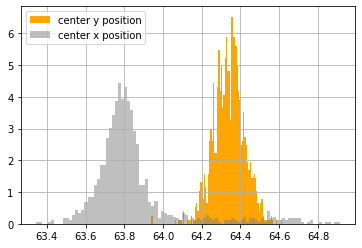

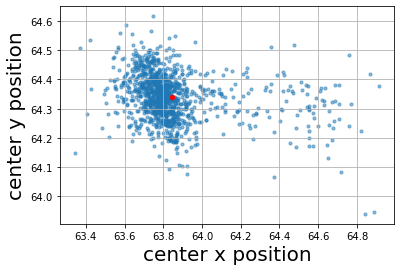

In [15]:
# find center position
center_pos = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        center_pos.append(gaussian_center(stack_4d_cropped[i, j], cbox_edge=30))
        
center_pos = np.asarray(center_pos)
center_pos = np.reshape(center_pos, (stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1))
print(center_pos.shape)
center_mean = np.mean(center_pos, axis=(0, 1))
print(center_mean)

# center distibution
plt.figure()
plt.hist(center_pos[:, :, 0].flatten(), bins=100, density=True, color="orange", label="center y position")
plt.hist(center_pos[:, :, 1].flatten(), bins=100, density=True, color="gray", alpha=0.5, label="center x position")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.scatter(center_pos[:, :, 1], center_pos[:, :, 0], s=10.0, alpha=0.5)
plt.grid()
plt.scatter(center_mean[1], center_mean[0], s=20, c="red")
plt.xlabel("center x position", fontsize=20)
plt.ylabel("center y position", fontsize=20)
plt.show()

In [29]:
# remove center beam
center_radius = 10
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        stack_4d_cropped[i, j] = remove_center_beam(stack_4d_cropped[i, j], 
                                                    center=center_mean.tolist(), cb_rad=center_radius)
print(np.max(stack_4d_cropped))
print(np.min(stack_4d_cropped))
print(np.mean(stack_4d_cropped))
#print(np.median(stack_4d_cropped))

0.0031550603
0.0
1.6927326e-05


[90]
(126, 9, 90)
(90,)


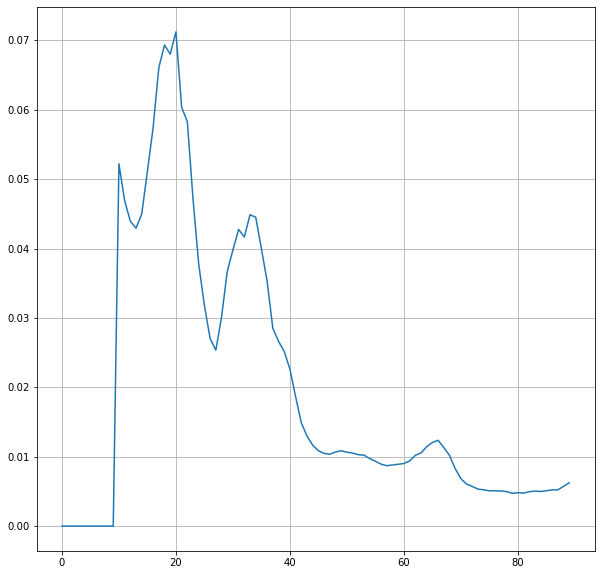

In [30]:
# radial average of DPs (not variance, intensity direcltly, RDF?)
radial_avg_stack = []
len_profile = []
for i in range(stack_4d_cropped.shape[0]):
    for j in range(stack_4d_cropped.shape[1]):
        radial_temp = radial_average_with_center(stack_4d_cropped[i, j], center=center_mean.tolist())
        len_profile.append(len(radial_temp))
        radial_avg_stack.append(radial_temp)

print(np.unique(len_profile))
for i in range(len(radial_avg_stack)):
    radial_avg_stack[i] = radial_avg_stack[i][:np.min(len_profile)]

radial_avg_stack = np.asarray(radial_avg_stack).reshape(stack_4d_cropped.shape[0], stack_4d_cropped.shape[1], -1)
print(radial_avg_stack.shape)

radial_avg_sum = np.sum(radial_avg_stack, axis=(0, 1))
print(radial_avg_sum.shape)

plt.figure(figsize=(10,10))
plt.plot(radial_avg_sum)
plt.grid()
plt.show()

In [31]:
# save (radial average, 3D)
radial_avg_stack = hys.signals.Signal1D(radial_avg_stack)
radial_avg_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_avg_stack.save(raw_adr[:-4]+"_radial_avg.hdf5")

In [32]:
%matplotlib qt
radial_avg_stack.plot()

In [ ]:
%matplotlib qt
radial_avg_stack.remove_background(zero_fill=True, fast=False)

In [ ]:
# save (radial average, 3D)
radial_avg_stack = hys.signals.Signal1D(radial_avg_stack)
radial_avg_stack.metadata.General.set_item("notes", center_mean.tolist())
radial_avg_stack.save(raw_adr[:-4]+"_radial_avg_background_subtracted.hdf5")